# Deep Cube Use Case 3: Fire Hazard Forecasting in the Mediterranean

 ![use case3 icon](static/use_case_banner.PNG) ![Deepcube logo](https://deepcube-h2020.eu/wp-content/uploads/2021/03/dc-logo-blue-sea-150.png)

# Notebook 2: Fire danger maps in Greece with Deep Learning models

## Introduction

This notebook shows how to load our pretrained models for Fire Danger prediction to perform inference on the published [greece_wildfire_datacube](https://zenodo.org/deposit/4943354) or its [cloud version](https://deepcube-h2020.eu/data-cubes/).

For details about how our models were trained, have a look at our relevant paper "Deep Learning Methods for Daily Wildfire Danger Forecasting" [available on arXiv](https://arxiv.org/abs/2111.02736), which is accepted to the workshop on Artificial Intelligence for Humanitarian Assistance and Disaster Response at the 35th Conference on Neural Information Processing Systems (NeurIPS 2021)

![arxiv paper](static/arxiv_paper.PNG)

# Initial Imports

We start by importing the libraries we need. Make sure to have them installed in your system. 

In [ ]:
import xarray as xr
import fsspec
import zarr

import numpy as np
import pandas as pd

import csv
import numpy as np
import matplotlib.pyplot as plt

import random
import os
from tqdm import tqdm
import gc
from pathlib import Path

import torchvision
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Access Datacube

Let's open the dataset with xarray

In [2]:
# uncomment the lines if you download the dataset locally
# !wget -O dataset_greece.nc https://zenodo.org/record/4943354/files/dataset_greece.nc?download=1
# ds = xr.open_dataset('./dataset_greece.nc')

# comment out the following two lines if you want to access the dataset locally
url = 'https://storage.de.cloud.ovh.net/v1/AUTH_84d6da8e37fe4bb5aea18902da8c1170/uc3/uc3cube.zarr'
ds = xr.open_zarr(fsspec.get_mapper(url), consolidated=True)


In [3]:
ds

<xarray.Dataset>
Dimensions:                  (time: 4314, x: 700, y: 562)
Coordinates:
    band                     int64 ...
    spatial_ref              (time) int64 dask.array<chunksize=(288,), meta=np.ndarray>
  * time                     (time) datetime64[ms] 2009-03-06 ... 2020-12-26
  * x                        (x) float64 19.86 19.87 19.89 ... 28.16 28.17 28.18
  * y                        (y) float64 41.62 41.61 41.59 ... 34.96 34.95 34.94
Data variables: (12/58)
    1 km 16 days EVI         (time, y, x) float64 dask.array<chunksize=(288, 50, 50), meta=np.ndarray>
    1 km 16 days NDVI        (time, y, x) float64 dask.array<chunksize=(288, 50, 50), meta=np.ndarray>
    1 km 16 days VI Quality  (time, y, x) float64 dask.array<chunksize=(288, 50, 50), meta=np.ndarray>
    ET_500m                  (time, y, x) float64 dask.array<chunksize=(288, 50, 50), meta=np.ndarray>
    ET_QC_500m               (time, y, x) float64 dask.array<chunksize=(288, 50, 50), meta=np.ndarray>
    FparExtra_QC             (time, y, x) float64 dask.array<chunksize=(288, 50, 50), meta=np.ndarray>
    ...                       ...
    population_density_2020  (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    roads_density_2020       (y, x) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    slope_max                (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    slope_mean               (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    slope_min                (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    slope_std                (y, x) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>

We see that the dataset has x,y and time dimensions.

More specifically it contains 4314 days (from 06/03/2009 to 06/12/2020) of 700x562 rasters

Dynamic variables like the `burned_areas` have all three dimensions, while static variables like `clc_2012` misses the temporal component and only has x, y dimensions.

# Method Description

![ethods architecture](static/methods.png)

From the datacube, we extract four different datasets that are used to train four different models.
For a given pixel (i.e., a cell representing a 1 km x 1 km square region) and a given day, we extract input-target pairs for 4 different modeling modalities:
- First, the pixel dataset, where we extract the input attributes and their last 10-day average (only for the dynamic input attributes). This is used to train a Random Forest (RF) model (is not shown in this notebook).
- Second, the temporal dataset, where we extract the last 10-day time-series of the input attributes. This is used to train an Long Short-Term Memory (LSTM) model.
- Third, the spatial dataset, where we extract 25km x 25km patches spatially centered around the given pixel. This is used to train a Convolutional Neural Network (CNN) model.
- Fourth, the spatio-temporal dataset, where we extract 25km x 25km x 10 days blocks centered spatially around the given pixel. This is used to train a convLSTM model.


# Load pretrained models

Pytorch lightning checkpoints are on `saved_models` directory.

The code for the models is in the `src` directory.

In [3]:
from src.greece_fire_models import CNN_fire_model, LSTM_fire_model, ConvLSTM_fire_model

In [4]:
# these are the features that change in time
dynamic_features = ['Fpar_500m', 'Lai_500m', 'LST_Day_1km', 'LST_Night_1km', '1 km 16 days NDVI', '1 km 16 days EVI', 'era5_max_u10', 'era5_max_v10', 'era5_max_t2m', 'era5_max_tp', 'era5_min_u10', 'era5_min_v10', 'era5_min_t2m']
# these are the features that remain the same through time
static_features= ['dem_mean', 'aspect_mean', 'slope_mean', 'roads_density_2020', 'population_density']
# the settings that were used to train our best models
best_settings = {
    'lstm' : {'dynamic_features' : dynamic_features, 'static_features' : static_features , 'hidden_size' : 64,  'lstm_layers':1, 'attention':False},
    'cnn' : {'dynamic_features' : dynamic_features, 'static_features' : static_features , 'hidden_size' : 16},
    'convlstm' : {'dynamic_features' : dynamic_features, 'static_features' : static_features , 'hidden_size' : 16,  'lstm_layers':1},

}

In [ ]:
model = 'lstm'
lstm = LSTM_fire_model(**best_settings[model]).load_from_checkpoint('saved_models/lstm.ckpt')

In [6]:
model = 'cnn'
cnn = CNN_fire_model(**best_settings[model]).load_from_checkpoint('saved_models/cnn.ckpt')

In [7]:
model = 'convlstm'
convlstm = ConvLSTM_fire_model(**best_settings[model]).load_from_checkpoint('saved_models/convlstm.ckpt')

# Do inference

The models have been trained using data for the years 2009-2019. We will perform inference on two days of the test set (year 2020).

In [9]:
from src.greece_fire_dataset import FireDatasetWholeDay

def predict_map(day, pl_module, access_mode, problem_class, patch_size, lag, dynamic_features, static_features, nan_fill, batch_size):
    """
    This function returns the predictions of model (pl_module) for a given day.
    """
    dataset = FireDatasetWholeDay(ds, day, access_mode, problem_class, patch_size, lag,
                                  dynamic_features,
                                  static_features,
                                  nan_fill)
    len_x = dataset.len_x
    len_y = dataset.len_y
    pl_module.eval()
    num_iterations = max(1, len(dataset) // batch_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, prefetch_factor=batch_size)
    outputs = []
    for i, (dynamic, static) in tqdm(enumerate(dataloader), total=num_iterations):

        if pl_module.on_gpu:
            inputs = inputs.cuda()
        logits = pl_module(inputs)
        preds_proba = torch.exp(logits)[:, 1]
        outputs.append(preds_proba.detach().cpu())
    outputs = torch.cat(outputs, dim=0)
    outputs = outputs.reshape(len_y, len_x)
    outputs = outputs.detach().cpu().numpy().squeeze()
    return outputs

4150


97it [04:18,  2.66s/it]                        
39it [05:21,  8.25s/it]                        
769it [06:18,  2.03it/s]                         


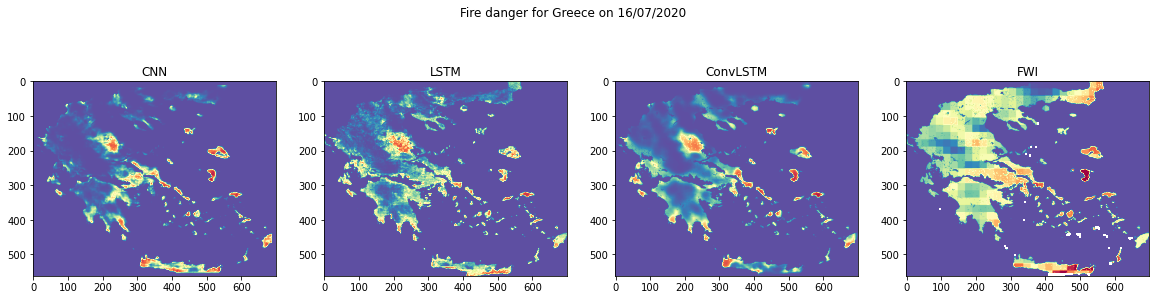

4155


97it [04:19,  2.67s/it]                        
39it [05:24,  8.33s/it]                        
769it [06:21,  2.02it/s]                         


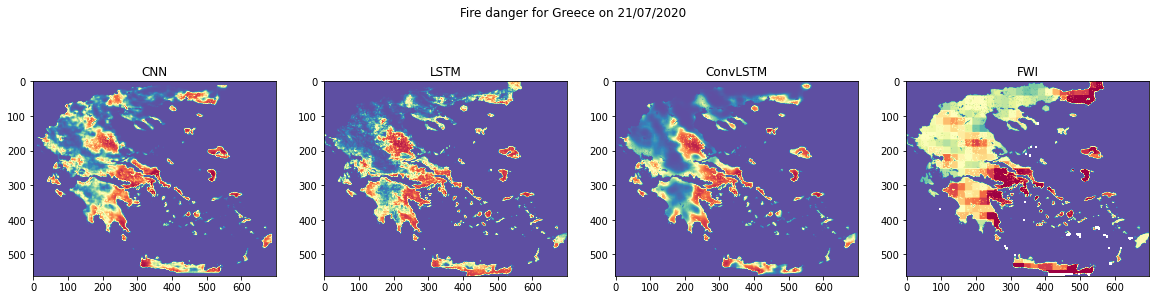

In [10]:
# days for which to create fire danger maps
days = [4150, 4155]
patch_size = 25
lag = 10
# value used to fill nans
nan_fill = -1.0

acc_mod_bs = [('spatial', cnn, 4096, 'CNN'), ('temporal', lstm, 10196, 'LSTM'), ('spatiotemporal', convlstm, 512, 'ConvLSTM'), ]
problem_class='classification'
num_workers = 12

# these are used to mask out land cover classes that are not supposed to be dangerous for fire (sea, water bodies, urban areas)
clc = np.isin(ds['clc_2012'].values, list(range(12, 33)), invert=True)
pop_den = np.isnan(ds['population_density_2012'].values)
for day in days:
    gc.collect()
    day = int(day)
    print(day)
    # get a validation batch from the validation dat loader
    fig, ax = plt.subplots(1,4, figsize=(20,5))
    fig.suptitle('Fire danger for Greece on {}'.format(ds['time'][day].dt.strftime('%d/%m/%Y').values))
    subplot_number = 141
    for i, (access_mode, pl_module, batch_size, name) in enumerate(acc_mod_bs):
        if access_mode == 'spatial':
            lag = 0
        else:
            lag = 10
        if access_mode == 'temporal':
            patch_size = 0
        else:
            patch_size = 25
        outputs =  predict_map(day, pl_module, access_mode, problem_class, patch_size, 
                               lag, dynamic_features, static_features, nan_fill, batch_size)
        outputs[clc] = 0
        outputs[pop_den] = 0
        plt.subplot(subplot_number), plt.imshow(outputs, vmin=0, vmax=1, cmap='Spectral_r')
        plt.title(name)
        subplot_number += 1
    fwi = ds.fwi[day].values
    fwi[clc] = 0
    fwi[pop_den] = 0
    plt.subplot(subplot_number), plt.imshow(fwi, vmin=0, vmax=50, cmap='Spectral_r')
    plt.title('FWI')
    plt.show()

We see that the danger maps created by the Deep Learning models follow closely, but offer a better resolution than the empirical Fire Weather Index that is widely used as an operational tool. This is quite an interesting result, considering that our models have been trained using the historical burned areas as target and do not have a direct notion of what Fire Danger is. This is quite a step forward in showing that fire danger can be learned in a data driven way and it is possible to leverage what DL models can learn from the complex interactions of the Fire Drivers.

# Discussion

We see that the danger maps created by the Deep Learning models follow closely, but offer a better resolution than the empirical Fire Weather Index that is widely used as an operational tool. This is quite an interesting result, considering that our models have been trained using the historical burned areas as target and do not have a direct notion of what Fire Danger is. This is quite a step forward in showing that fire danger can be learned in a data driven way and it is possible to leverage what DL models can learn from the complex interactions of the Fire Drivers.

In this notebook, we saw how to load pytorch lighning pretrained Deep Learning modules and use them on inference to create fire danger maps. In a later notebook we'll use **explainable AI methods** to understand our models' predictions. Stay tuned!

# Acknowledgements

Research funded by the EU H2020 DeepCube ’Explainable AI pipelines for big Copernicus data’.


Notebook Authors: *Ioannis Prapas (https://github.com/iprapas), Spyros Kondylatos (https://github.com/skondylatos)*